# <center> <a href="https://datatopics.worldbank.org/world-development-indicators/">Working with World Development Indicators (WDI)</a></center>

<center><a href="https://data.worldbank.org/indicator"> <img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wb-header-en.svg" alt="WDI" width=1000/></a>  </center>

* World Development Indicators (WDI) is the World Bank’s premier compilation of cross-country comparable data on development.

* Widely used for analysis

* Free and easy to access

* Lot's of variables are available, from multiple sources that have been collected by the WB. 

* If you check [their website](https://data.worldbank.org/) you can see more information on them, also identify and search the variables you may want to focus on. 

# Setup

# Import Modules and set Paths

In [ ]:
# Basic Packages
from __future__ import division
import os
from datetime import datetime

# Web & file access
import requests
import io

# Import display options for showing websites
from IPython.display import IFrame, HTML

In [ ]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

%pylab --no-import-all
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

import plotly.express as px
import plotly.graph_objects as go

from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# Next line can import all of plotnine, but may overwrite things? Better import each function/object you need
#from plotnine import *

Using matplotlib backend: <object object at 0x7f066a211bb0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
/opt/conda/lib/python3.10/site-packages/plotnine/geoms/geom_map.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).


In [ ]:
# Data
import pandas as pd
import numpy as np
from pandas_datareader import data, wb

# GIS & maps
import geopandas as gpd
gp = gpd
import georasters as gr
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

In [ ]:
# Data Munging
from itertools import product, combinations
import difflib
import pycountry
import geocoder
from geonamescache.mappers import country
mapper = country(from_key='name', to_key='iso3')
mapper2 = country(from_key='iso3', to_key='iso')
mapper3 = country(from_key='iso3', to_key='name')

# Regressions & Stats
from scipy.stats import norm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation

In [ ]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

In [ ]:
currentYear = datetime.now().year
year = min(2020, currentYear-2)

# Getting WDI data from the World Bank

* [Head over to the WDI Indicator website](https://data.worldbank.org/indicator) 

* Search for the variable you are interested in

    (e.g., **GDP per capita, PPP (constant 2017 international $)**)

* The link will become [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD)

    (if feasible it will display a figure)

In [ ]:
url = 'https://data.worldbank.org/share/widget?indicators=NY.GDP.PCAP.PP.KD'
IFrame(url, width=500, height=300)

# Downloading the data

* Suboptimal: Download from the website 

    (Not best approach, since you need to do it for every variable every time data is updated)

* Using API: Let's instead use the wonderful [pandas-data-reader package](https://pandas-datareader.readthedocs.io/en/latest/index.html)

# <font size="30">WDI with</font>
# <center> <a href="https://pandas-datareader.readthedocs.io/en/latest/index.html"><img src="https://pandas-datareader.readthedocs.io/en/latest/_static/pandas-datareader-plain.svg" alt="pandas-data-reader" width=700/></a></center>

In [ ]:
url = 'https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-wb'
IFrame(url, width=800, height=400)

## Steps

1. Import **pandas-data-reader**
```python
from pandas_datareader import data, wb
```

2. Download basic country/aggregates information
```python
wbcountries = wb.get_countries()
```

3. Clean up
```python
# If you want to keep aggregate data for regions or world comment out next line
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'
```

In [ ]:
wbcountries = wb.get_countries()
wbcountries = wbcountries.loc[wbcountries.region.isin(['Aggregates'])==False].reset_index(drop=True)
wbcountries['name'] = wbcountries.name.str.strip()
wbcountries['incomeLevel'] = wbcountries['incomeLevel'].str.title()
wbcountries.loc[wbcountries.iso3c=='VEN', 'incomeLevel'] = 'Upper Middle Income'

4. Get Indicators of interest

* Few and varied indicators of interest: 
    
    Search for the variable on the WDI Indicator website (as explained above)
        
    (e.g., [https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD](https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.KD))
        
    Add the indicator's name into a list of indicators in **Python**

    (i.e., everything that comes after **https://data.worldbank.org/indicator/**. E.g., `NY.GDP.PCAP.PP.KD`)
        

```python
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']
```

In [ ]:
wdi_indicators = ['NY.GDP.PCAP.PP.KD', 'NY.GDP.PCAP.KD', 'SL.GDP.PCAP.EM.KD', 'SP.POP.GROW', 'SP.POP.TOTL', 'SP.DYN.WFRT', 'SP.DYN.TFRT.IN']

* Many related indicators or mass search

    (e.g., search for all variables containing the word *population*)

```python
popvars = wb.search(string='population')
```
    
This returns a dataframe, where the column `id` has the IDs for the indicators

In [ ]:
popvars = wb.search(string='population')
popvars.head()

id  \
24      1.1_ACCESS.ELECTRICITY.TOT   
39    1.2_ACCESS.ELECTRICITY.RURAL   
40    1.3_ACCESS.ELECTRICITY.URBAN   
161             2.1_ACCESS.CFT.TOT   
1152           BAR.NOED.1519.FE.ZS   

                                                   name unit  \
24        Access to electricity (% of total population)        
39        Access to electricity (% of rural population)        
40        Access to electricity (% of urban population)        
161   Access to Clean Fuels and Technologies for coo...        
1152  Barro-Lee: Percentage of female population age...        

                          source  \
24    Sustainable Energy for All   
39    Sustainable Energy for All   
40    Sustainable Energy for All   
161   Sustainable Energy for All   
1152        Education Statistics   

                                             sourceNote  \
24    Access to electricity is the percentage of pop...   
39    Access to electricity is the percentage of rur...   
40    Access to electricity is the percentage of tot...   
161                                                       
1152  Percentage of female population age 15-19 with...   

                                     sourceOrganization      topics  
24    b'World Bank Global Electrification Database 2...              
39    b'World Bank Global Electrification Database 2...              
40    b'World Bank Global Electrification Database 2...              
161                                                 b''              
1152  b'Robert J. Barro and Jong-Wha Lee: http://www...  Education

5. Download data for selected indicators, years, and countries

```python
wdi = wb.download(indicator=wdi_indicators,
                  country=list_of_countries_ISO_A2_codes, 
                  start=start_year, 
                  end=end_year)
```

6. Clean up and process data
```python
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
```

In [ ]:
wdi = wb.download(indicator=wdi_indicators, country=wbcountries.iso2c.values, start=1950, end=year)
wdi = wdi.reset_index()
wdi['year'] = wdi.year.astype(int)
wdi['gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD']
wdi['ln_gdp_pc'] = wdi['NY.GDP.PCAP.PP.KD'].apply(np.log)
wdi['ln_pop'] = wdi['SP.POP.TOTL'].apply(np.log)
wdi.head()

/opt/conda/lib/python3.10/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: JG, XK


country  year  NY.GDP.PCAP.PP.KD  NY.GDP.PCAP.KD  SL.GDP.PCAP.EM.KD  \
0   Aruba  2020       29236.047264    23015.741867                NaN   
1   Aruba  2019       38511.336876    30317.606908                NaN   
2   Aruba  2018       39597.659876    31172.802193                NaN   
3   Aruba  2017       38868.333923    30598.648727                NaN   
4   Aruba  2016       36504.688731    28737.896241                NaN   

   SP.POP.GROW  SP.POP.TOTL  SP.DYN.WFRT  SP.DYN.TFRT.IN        gdp_pc  \
0     0.134255     106585.0          NaN           1.325  29236.047264   
1     0.451970     106442.0          NaN           1.486  38511.336876   
2     0.494795     105962.0          NaN           1.587  39597.659876   
3     0.537296     105439.0          NaN           1.839  38868.333923   
4     0.590062     104874.0          NaN           1.953  36504.688731   

   ln_gdp_pc     ln_pop  
0  10.283158  11.576698  
1  10.558708  11.575356  
2  10.586525  11.570836  
3  10.567935  11.565888  
4  10.505196  11.560515

7. Add other WB data from the ``wbcountries`` dataframe
```python
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
```

In [ ]:
wdi = wbcountries.merge(wdi, left_on='name', right_on='country')
wdi.head()

iso3c iso2c   name                      region adminregion  incomeLevel  \
0   ABW    AW  Aruba  Latin America & Caribbean               High Income   
1   ABW    AW  Aruba  Latin America & Caribbean               High Income   
2   ABW    AW  Aruba  Latin America & Caribbean               High Income   
3   ABW    AW  Aruba  Latin America & Caribbean               High Income   
4   ABW    AW  Aruba  Latin America & Caribbean               High Income   

      lendingType capitalCity  longitude  latitude  ... NY.GDP.PCAP.PP.KD  \
0  Not classified  Oranjestad   -70.0167   12.5167  ...      29236.047264   
1  Not classified  Oranjestad   -70.0167   12.5167  ...      38511.336876   
2  Not classified  Oranjestad   -70.0167   12.5167  ...      39597.659876   
3  Not classified  Oranjestad   -70.0167   12.5167  ...      38868.333923   
4  Not classified  Oranjestad   -70.0167   12.5167  ...      36504.688731   

   NY.GDP.PCAP.KD  SL.GDP.PCAP.EM.KD  SP.POP.GROW  SP.POP.TOTL  SP.DYN.WFRT  \
0    23015.741867                NaN     0.134255     106585.0          NaN   
1    30317.606908                NaN     0.451970     106442.0          NaN   
2    31172.802193                NaN     0.494795     105962.0          NaN   
3    30598.648727                NaN     0.537296     105439.0          NaN   
4    28737.896241                NaN     0.590062     104874.0          NaN   

   SP.DYN.TFRT.IN        gdp_pc  ln_gdp_pc     ln_pop  
0           1.325  29236.047264  10.283158  11.576698  
1           1.486  38511.336876  10.558708  11.575356  
2           1.587  39597.659876  10.586525  11.570836  
3           1.839  38868.333923  10.567935  11.565888  
4           1.953  36504.688731  10.505196  11.560515  

[5 rows x 22 columns]

# Regression Analysis with 
<center><a href="statsmodels"><img src="https://www.statsmodels.org/stable/_images/statsmodels-logo-v2-horizontal.svg" alt="statsmodels" width=700/></a></center>

In [ ]:
url = 'https://www.statsmodels.org/stable/index.html'
IFrame(url, width=800, height=400)

## Linear Regressions using OLS 

It is very easy to run a regression in **statsmodels**. 

We only need

* Data in a **pandas** dataframe

* An equation we want to estimate

Equations are strings of the form 
```python
'dependent_variable ~ indep_var_1 + function(indep_var2) + C(indep_var3)'
```

where:
* `dependent_variable` is the outcome variable of interest
* `indep_var_1` is the first independent variable        
* `function(indep_var2)` is a function of another independent variable (if needed)      
* `C(indep_var3)` defines fixed-effects/dummies based on categories given in indep_var3

## Simple Regression of Log[GDP pc] and Latitude

In [ ]:
dffig = wdi.loc[wdi.year==year]\
            .dropna(subset=['ln_gdp_pc', 'latitude', 'ln_pop'])\
            .sort_values(by='region').reset_index()

In [ ]:
mod = smf.ols(formula='ln_gdp_pc ~ latitude', data=dffig, missing='drop').fit()

In [ ]:
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.231   
Dependent Variable: ln_gdp_pc        AIC:                547.5607
Date:               2024-02-28 20:02 BIC:                554.0653
No. Observations:   191              Log-Likelihood:     -271.78 
Df Model:           1                F-statistic:        58.08   
Df Residuals:       189              Prob (F-statistic): 1.18e-12
R-squared:          0.235            Scale:              1.0187  
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    8.9478     0.0920   97.3030   0.0000   8.7664   9.1292
latitude     0.0231     0.0030    7.6213   0.0000   0.0171   0.0291
-----------------------------------------------------------------
Omnibus:               0.534        Durbin-Watson:          1.357
Prob(Omnibus):         0.766        Jarque-Bera (JB):       0.656
Skew:                  -0.002       Prob(JB):               0.720
Kurtosis:              2.713        Condition No.:          38   
=================================================================

"""

## Plot Data and OLS Regression Predictions

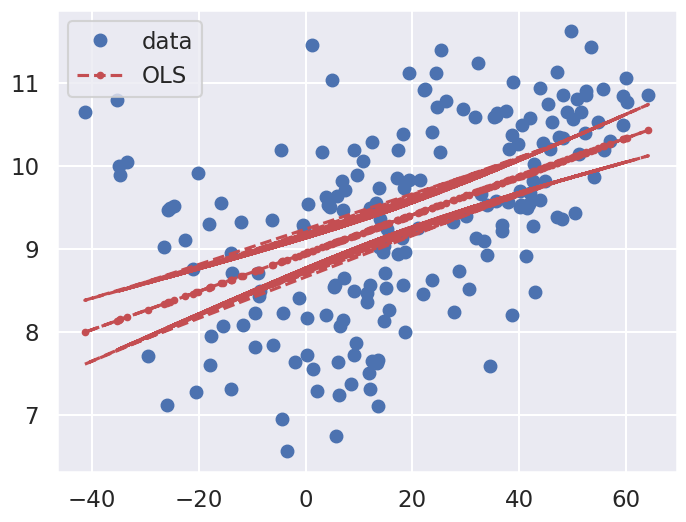

In [ ]:
pred_ols = mod.get_prediction()
iv_l = pred_ols.summary_frame()["mean_ci_lower"]
iv_u = pred_ols.summary_frame()["mean_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dffig.latitude, dffig.ln_gdp_pc, "o", label="data")
ax.plot(dffig.latitude, mod.fittedvalues, "r--.", label="OLS")
ax.plot(dffig.latitude, iv_u, "r--")
ax.plot(dffig.latitude, iv_l, "r--")
ax.legend(loc="best")

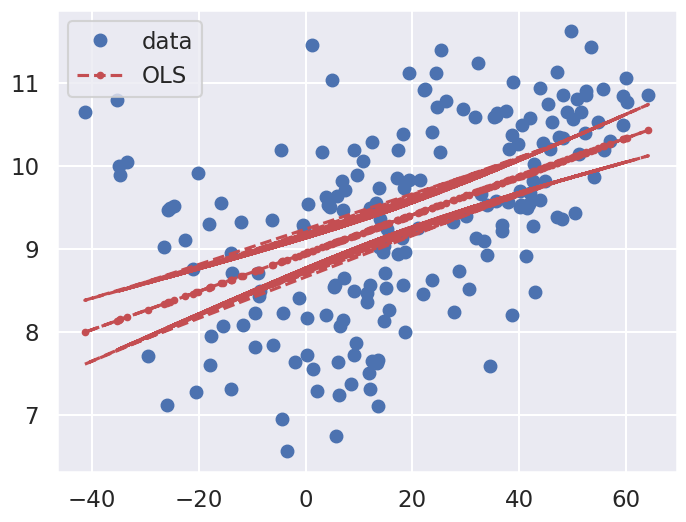

In [ ]:
fig

## Simple Regression of Log[GDP pc] and Latitude accounting for WB region dummies

In [ ]:
mod2 = smf.ols(formula='ln_gdp_pc ~ latitude + C(region)', data=dffig, missing='drop').fit()

In [ ]:
mod2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.499   
Dependent Variable:         ln_gdp_pc               AIC:                       471.4782
Date:                       2024-02-28 20:02        BIC:                       497.4964
No. Observations:           191                     Log-Likelihood:            -227.74 
Df Model:                   7                       F-statistic:               28.06   
Df Residuals:               183                     Prob (F-statistic):        5.29e-26
R-squared:                  0.518                   Scale:                     0.66339 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.3602   0.1478 63.3513 0.0000  9.0686  9.6517
C(region)[T.Europe & Central Asia]       0.8083   0.2622  3.0823 0.0024  0.2909  1.3257
C(region)[T.Latin America & Caribbean ]  0.2140   0.2010  1.0648 0.2884 -0.1825  0.6106
C(region)[T.Middle East & North Africa]  0.5286   0.2646  1.9978 0.0472  0.0066  1.0506
C(region)[T.North America]               1.5907   0.5140  3.0947 0.0023  0.5765  2.6048
C(region)[T.South Asia]                 -0.6344   0.3324 -1.9087 0.0579 -1.2902  0.0214
C(region)[T.Sub-Saharan Africa ]        -1.2727   0.1912 -6.6570 0.0000 -1.6499 -0.8955
latitude                                 0.0011   0.0043  0.2638 0.7923 -0.0074  0.0097
---------------------------------------------------------------------------------------
Omnibus:                      1.017               Durbin-Watson:                  1.969
Prob(Omnibus):                0.601               Jarque-Bera (JB):               1.082
Skew:                         0.170               Prob(JB):                       0.582
Kurtosis:                     2.858               Condition No.:                  287  
=======================================================================================

"""

## Simple Regression of Log[GDP pc] and absolute latitude, accounting for WB region dummies

In [ ]:
mod3 = smf.ols(formula='ln_gdp_pc ~ np.abs(latitude) + C(region)', data=dffig, missing='drop').fit()

In [ ]:
mod3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.524   
Dependent Variable:         ln_gdp_pc               AIC:                       461.6336
Date:                       2024-02-28 20:02        BIC:                       487.6518
No. Observations:           191                     Log-Likelihood:            -222.82 
Df Model:                   7                       F-statistic:               30.93   
Df Residuals:               183                     Prob (F-statistic):        5.30e-28
R-squared:                  0.542                   Scale:                     0.63007 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.0078   0.1829 49.2518 0.0000  8.6470  9.3687
C(region)[T.Europe & Central Asia]       0.2184   0.2734  0.7988 0.4254 -0.3210  0.7578
C(region)[T.Latin America & Caribbean ]  0.2366   0.1959  1.2079 0.2286 -0.1499  0.6231
C(region)[T.Middle East & North Africa]  0.2885   0.2505  1.1518 0.2509 -0.2057  0.7826
C(region)[T.North America]               1.1726   0.5017  2.3371 0.0205  0.1827  2.1626
C(region)[T.South Asia]                 -0.7372   0.3172 -2.3237 0.0212 -1.3631 -0.1113
C(region)[T.Sub-Saharan Africa ]        -1.1552   0.1887 -6.1210 0.0000 -1.5275 -0.7828
np.abs(latitude)                         0.0210   0.0067  3.1230 0.0021  0.0077  0.0342
---------------------------------------------------------------------------------------
Omnibus:                      3.205               Durbin-Watson:                  1.870
Prob(Omnibus):                0.201               Jarque-Bera (JB):               2.940
Skew:                         0.301               Prob(JB):                       0.230
Kurtosis:                     3.079               Condition No.:                  284  
=======================================================================================

"""

## Simple Regression of Log[GDP pc] and Log[absolute latitude] accounting for WB region dummies

In [ ]:
mod4 = smf.ols(formula='ln_gdp_pc ~ np.log(np.abs(latitude)) + C(region)', data=dffig, missing='drop').fit()

In [ ]:
mod4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Ordinary least squares
=======================================================================================
Model:                      OLS                     Adj. R-squared:            0.502   
Dependent Variable:         ln_gdp_pc               AIC:                       470.6030
Date:                       2024-02-28 20:02        BIC:                       496.6212
No. Observations:           191                     Log-Likelihood:            -227.30 
Df Model:                   7                       F-statistic:               28.31   
Df Residuals:               183                     Prob (F-statistic):        3.52e-26
R-squared:                  0.520                   Scale:                     0.66036 
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------------------------
Intercept                                9.1951   0.2307 39.8493 0.0000  8.7398  9.6504
C(region)[T.Europe & Central Asia]       0.7585   0.2125  3.5690 0.0005  0.3392  1.1778
C(region)[T.Latin America & Caribbean ]  0.2052   0.2007  1.0225 0.3079 -0.1908  0.6013
C(region)[T.Middle East & North Africa]  0.4924   0.2502  1.9683 0.0505 -0.0012  0.9861
C(region)[T.North America]               1.5450   0.4993  3.0946 0.0023  0.5600  2.5301
C(region)[T.South Asia]                 -0.6482   0.3243 -1.9990 0.0471 -1.2880 -0.0084
C(region)[T.Sub-Saharan Africa ]        -1.2495   0.1915 -6.5247 0.0000 -1.6273 -0.8716
np.log(np.abs(latitude))                 0.0698   0.0732  0.9541 0.3413 -0.0746  0.2143
---------------------------------------------------------------------------------------
Omnibus:                      1.176               Durbin-Watson:                  1.947
Prob(Omnibus):                0.555               Jarque-Bera (JB):               1.202
Skew:                         0.186               Prob(JB):                       0.548
Kurtosis:                     2.888               Condition No.:                  29   
=======================================================================================

"""

# Producing a nice table with **stargazer**

In [ ]:
url = 'https://nbviewer.org/github/mwburke/stargazer/blob/master/examples.ipynb'
IFrame(url, width=800, height=400)

## Add the estimated models to **Stargazer**

In [ ]:
stargazer = Stargazer([mod, mod2, mod3, mod4])

In [ ]:
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
#stargazer.dep_var_name = ''
stargazer.dependent_variable = ' Log[GDP per capita (' + str(year) + ')]'
stargazer.custom_columns(['Latitude', 'Abs(Latitude)', 'Log[Abs(Latitude)]'], [2, 1, 1])
#stargazer.show_model_numbers(False)
stargazer.rename_covariates({'latitude':'Latitude', 
                             'np.abs(latitude)':'Absolute Latitude',
                             'np.log(np.abs(latitude))':'Log[Absolute Latitude]',})
stargazer.add_line('WB Region FE', ['No', 'Yes', 'Yes', 'Yes'], LineLocation.FOOTER_TOP)
stargazer.covariate_order(['latitude', 'np.abs(latitude)', 'np.log(np.abs(latitude))'])
stargazer.cov_spacing = 2

In [ ]:
stargazer

## To show the table
```python
HTML(stargazer.render_html())
```

In [ ]:
HTML(stargazer.render_html())

## To export the table to another file

In [ ]:
file_name = "table.html" #Include directory path if needed
html_file = open(pathgraphs + file_name, "w" ) #This will overwrite an existing file
html_file.write( stargazer.render_html() )
html_file.close()

In [ ]:
url = pathgraphs + 'table.html'
url = 'https://smu-econ-growth.github.io/EconGrowthUG-Slides-Working-with-WDI/table.html'
IFrame(url, width=500, height=300)

# Plotting WDI data

## Many options
* Since the data is a **pandas** dataframe, we could just use its functions as [we did previously](./Intro-Data-Analysis-Pandas.ipynb)
* Use the **[seaborn](https://seaborn.pydata.org/index.html)** package
* Use the **[plotly](https://plotly.com/python/)** package
* Use the **[plotnine](https://plotnine.readthedocs.io/en/stable/)** package

# Plots with 
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

In [ ]:
url = 'https://seaborn.pydata.org/examples/index.html'
IFrame(url, width=800, height=400)

Let's create a [Scatterplot with varying point sizes and hues](https://seaborn.pydata.org/examples/scatter_bubbles.html) that plots the latitude and Log[GDP per capita] of each country and uses its log-population and the WB region in the last available year as the size and hue.

## Using [`relplot`](https://seaborn.pydata.org/generated/seaborn.relplot.html#seaborn.relplot)

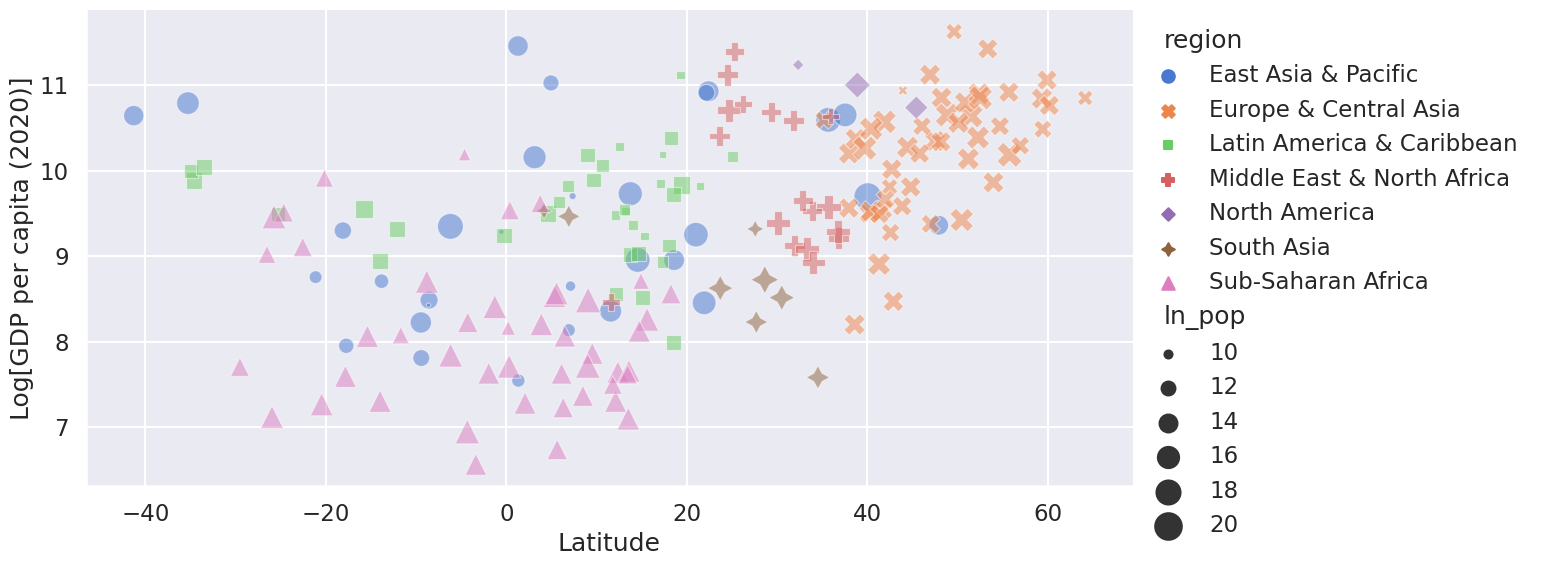

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

g = sns.relplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                height=6,
                aspect=2,
                palette="muted",
               )
g.set_axis_labels('Latitude', 'Log[GDP per capita (' + str(year) + ')]')

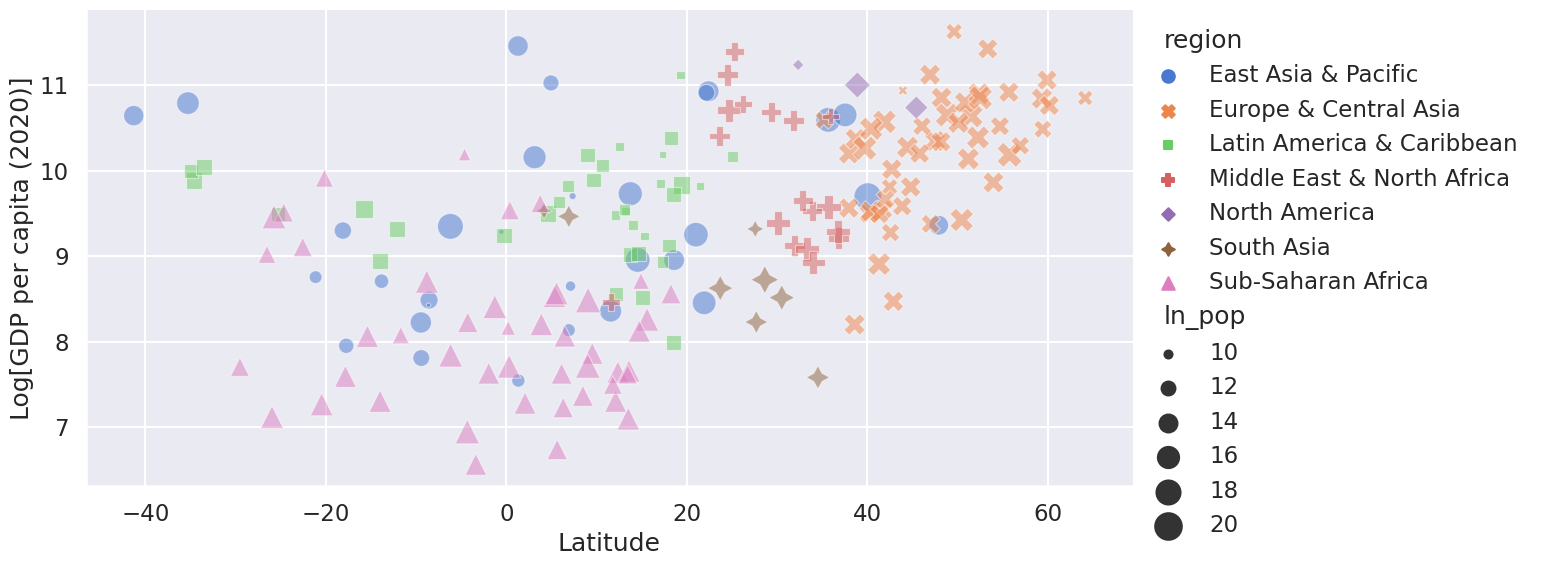

In [ ]:
g.fig

# Using [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)

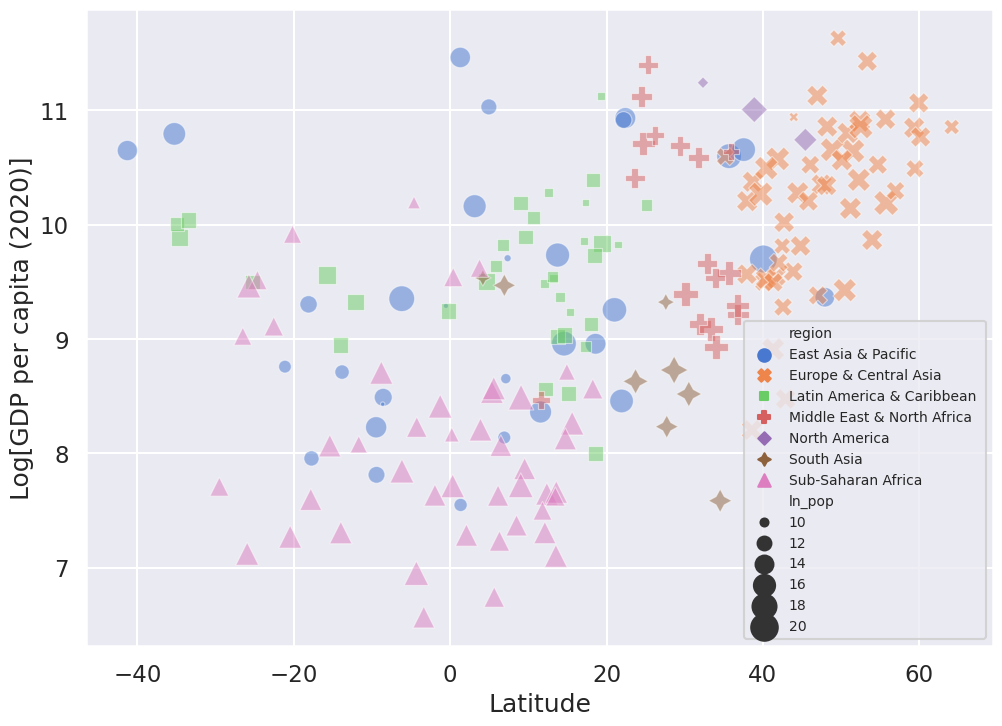

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_context("talk")

fig, ax = plt.subplots()
sns.scatterplot(x="latitude", 
                y="ln_gdp_pc", 
                data=dffig,
                hue="region",
                hue_order = dffig.region.drop_duplicates().sort_values(),
                style="region",
                style_order = dffig.region.drop_duplicates().sort_values(),
                size="ln_pop",
                sizes=(10, 400), 
                alpha=.5, 
                palette="muted",
                ax=ax
               )
ax.set_xlabel('Latitude')
ax.set_ylabel('Log[GDP per capita (' + str(year) + ')]')
ax.legend(fontsize=10)

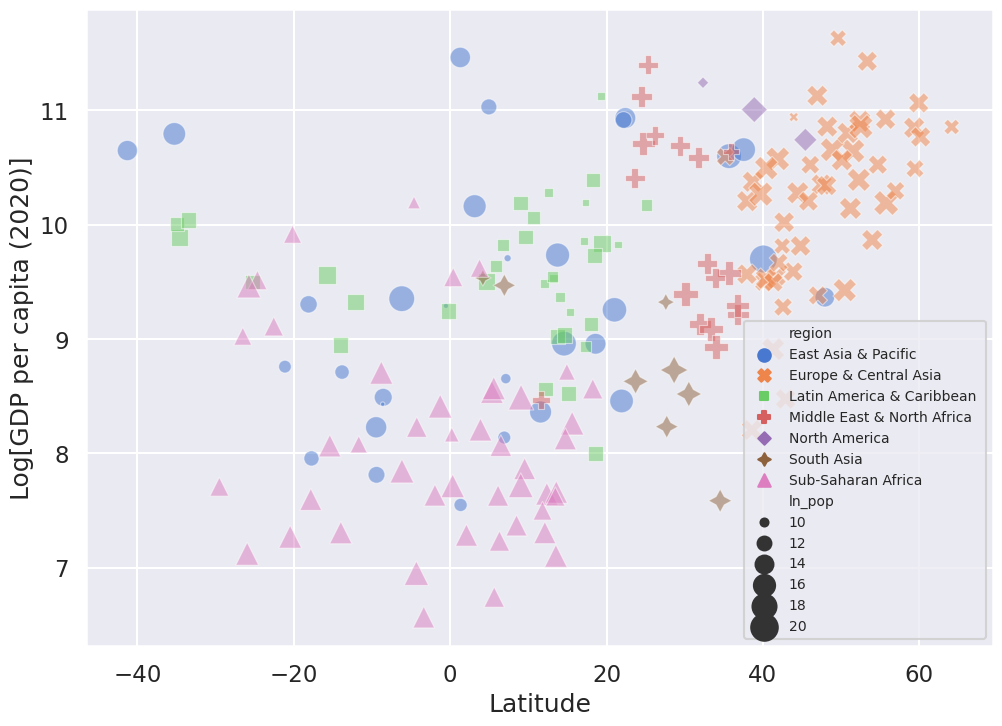

In [ ]:
fig

# Based on **seaborn** we can create a useful functions that create plots for us
## E.g., scatter plots with labels, OLS regression lines, 45 degree lines, etc

In [ ]:
def my_xy_plot(dfin, 
               x='SP.POP.GROW', 
               y='ln_gdp_pc', 
               labelvar='iso3c', 
               dx=0.006125, 
               dy=0.006125, 
               xlogscale=False, 
               ylogscale=False,
               xlabel='Growth Rate of Population', 
               ylabel='Log[Income per capita in ' +  str(year) + ']',
               labels=False,
               xpct = False,
               ypct = False,
               OLS=False,
               OLSlinelabel='OLS',
               ssline=False,
               sslinelabel='45 Degree Line',
               filename='income-pop-growth.pdf',
               hue='region',
               hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                          'Latin America & Caribbean ', 'Middle East & North Africa',
                          'North America', 'South Asia', 'Sub-Saharan Africa '],
               style='incomeLevel', 
               style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
               palette=None,
               size=None,
               sizes=None,
               legend_fontsize=10,
               label_font_size=12,
               save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels.
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.scatterplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    #hue='incomeLevel',
                    #hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    #hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                    #           'Latin America & Caribbean ', 'Middle East & North Africa',
                    #           'North America', 'South Asia', 'Sub-Saharan Africa '],
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                    size=size,
                    sizes=sizes,
                    #palette=sns.color_palette("Blues_r", df[hue].unique().shape[0]+6)[:df[hue].unique().shape[0]*2:2],
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_font_size, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!=hue) & (labels!=style) & (labels!=size)])
    labels = list(labels[(labels!=hue) & (labels!=style) & (labels!=size)])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

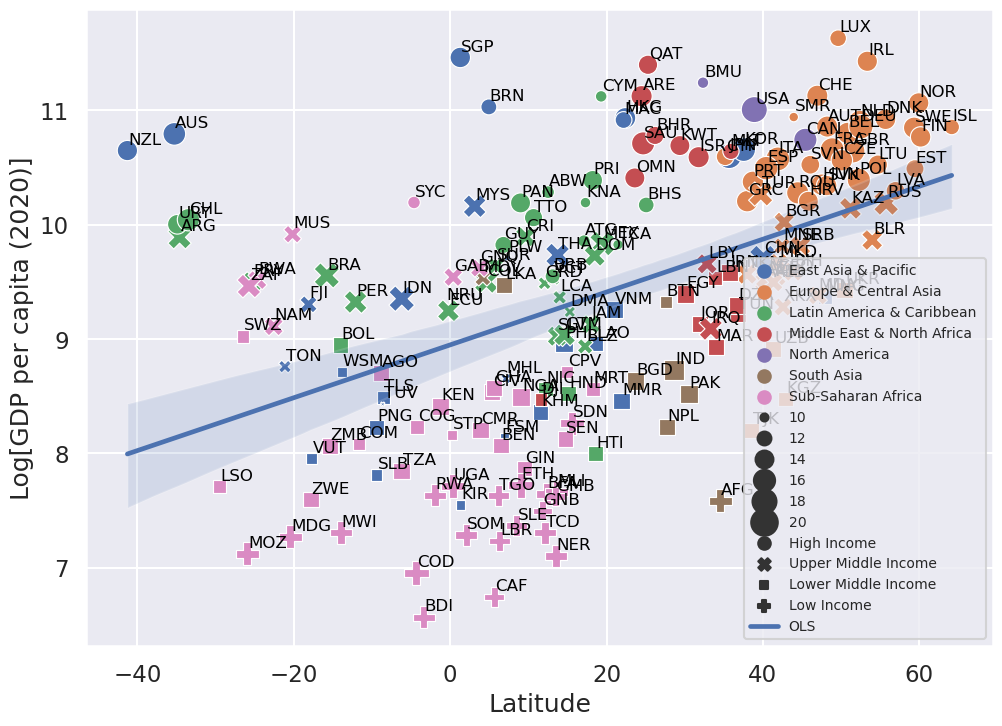

In [ ]:
g = my_xy_plot(dffig, 
               x='latitude', 
               y='ln_gdp_pc', 
               xlabel='Latitude', 
               ylabel='Log[GDP per capita (' + str(year) +')]', 
               OLS=True, 
               labels=True, 
               size="ln_pop", 
               sizes=(10, 400), 
               filename='ln-gdp-pc-latitude.pdf')

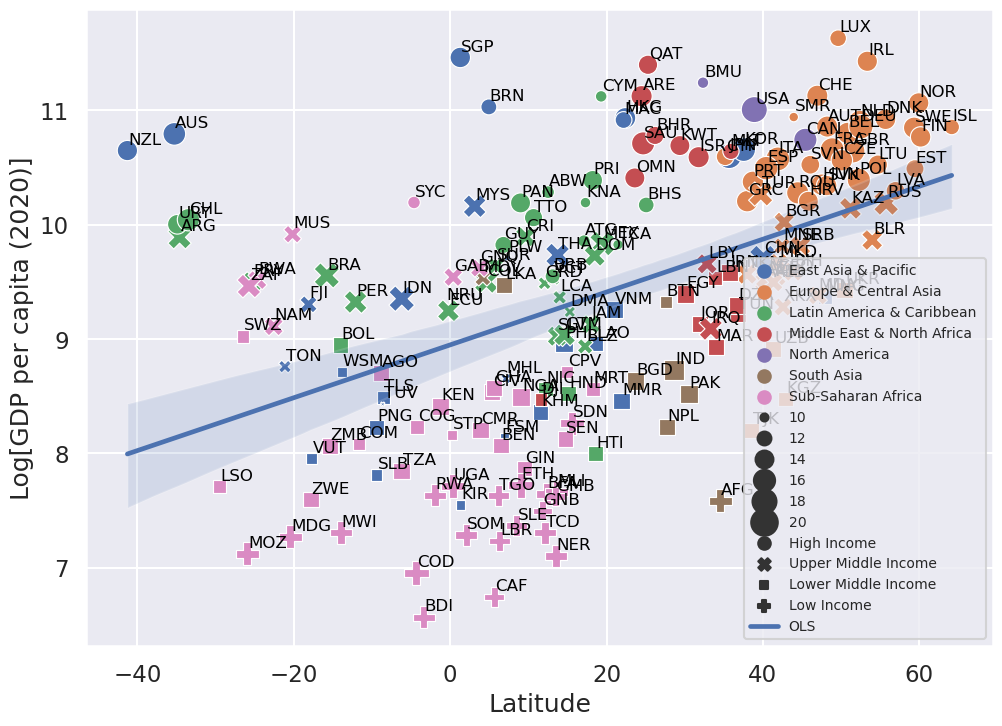

In [ ]:
g

## Plot the evolution of variables across time by groups

In [ ]:
def my_xy_line_plot(dfin, 
                    x='year', 
                    y='ln_gdp_pc', 
                    labelvar='iso3c', 
                    dx=0.006125, 
                    dy=0.006125, 
                    xlogscale=False, 
                    ylogscale=False,
                    xlabel='Growth Rate of Population', 
                    ylabel='Log[Income per capita in ' +  str(year) + ']',
                    labels=False,
                    xpct = False,
                    ypct = False,
                    OLS=False,
                    OLSlinelabel='OLS',
                    ssline=False,
                    sslinelabel='45 Degree Line',
                    filename='income-pop-growth.pdf',
                    hue='region',
                    hue_order=['East Asia & Pacific', 'Europe & Central Asia',
                               'Latin America & Caribbean ', 'Middle East & North Africa',
                               'North America', 'South Asia', 'Sub-Saharan Africa '],
                    style='incomeLevel', 
                    style_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                    palette=None,
                    legend_fontsize=10,
                    label_fontsize=12,
                    loc=None,
                    save=True):
    '''
    Plot the association between x and var in dataframe using labelvar for labels. 
    '''
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_context("talk")
    df = dfin.copy()
    df = df.dropna(subset=[x, y]).reset_index(drop=True)
    # Plot
    k = 0
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, data=df, ax=ax, 
                    hue=hue,
                    hue_order=hue_order,
                    alpha=1, 
                    style=style, 
                    style_order=style_order,
                    palette=palette,
                )
    if OLS:
        sns.regplot(x=x, y=y, data=df, ax=ax, label=OLSlinelabel, scatter=False)
    if ssline:
        ax.plot([df[x].min()*.99, df[x].max()*1.01], [df[x].min()*.99, df[x].max()*1.01], c='r', label=sslinelabel)
    if labels:
        movex = df[x].mean() * dx
        movey = df[y].mean() * dy
        for line in range(0,df.shape[0]):
            ax.text(df[x][line]+movex, df[y][line]+movey, df[labelvar][line], horizontalalignment='left', fontsize=label_fontsize, color='black')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xpct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
    if ypct:
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        yticks = mtick.FormatStrFormatter(fmt)
        ax.yaxis.set_major_formatter(yticks)
    if ylogscale:
        ax.set(yscale="log")
    if xlogscale:
        ax.set(xscale="log")
    handles, labels = ax.get_legend_handles_labels()
    handles = np.array(handles)
    labels = np.array(labels)
    handles = list(handles[(labels!='region') & (labels!='incomeLevel')])
    labels = list(labels[(labels!='region') & (labels!='incomeLevel')])
    ax.legend(handles=handles, labels=labels, fontsize=legend_fontsize, loc=loc)
    if save:
        plt.savefig(pathgraphs + filename, dpi=300, bbox_inches='tight')
    return fig

## Log[GDP per capita across the world] by WB Income Groups

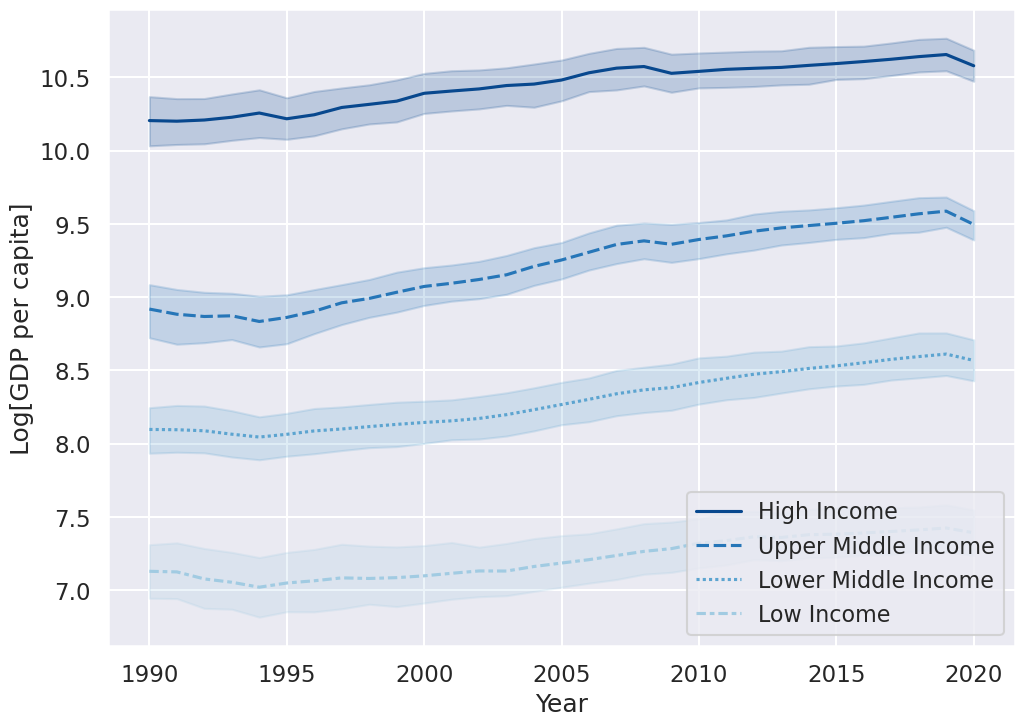

In [ ]:
palette=sns.color_palette("Blues_r", wdi['incomeLevel'].unique().shape[0]+6)[:wdi['incomeLevel'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                x='year', 
                y='ln_gdp_pc', 
                xlabel='Year',
                ylabel='Log[GDP per capita]',
                filename='ln-gdp-pc-income-groups-TS.pdf',
                hue='incomeLevel',
                hue_order=['High Income', 'Upper Middle Income', 'Lower Middle Income', 'Low Income'],
                palette=palette,
                OLS=False, 
                labels=False,
                legend_fontsize=16,
                loc='lower right',
                save=True)

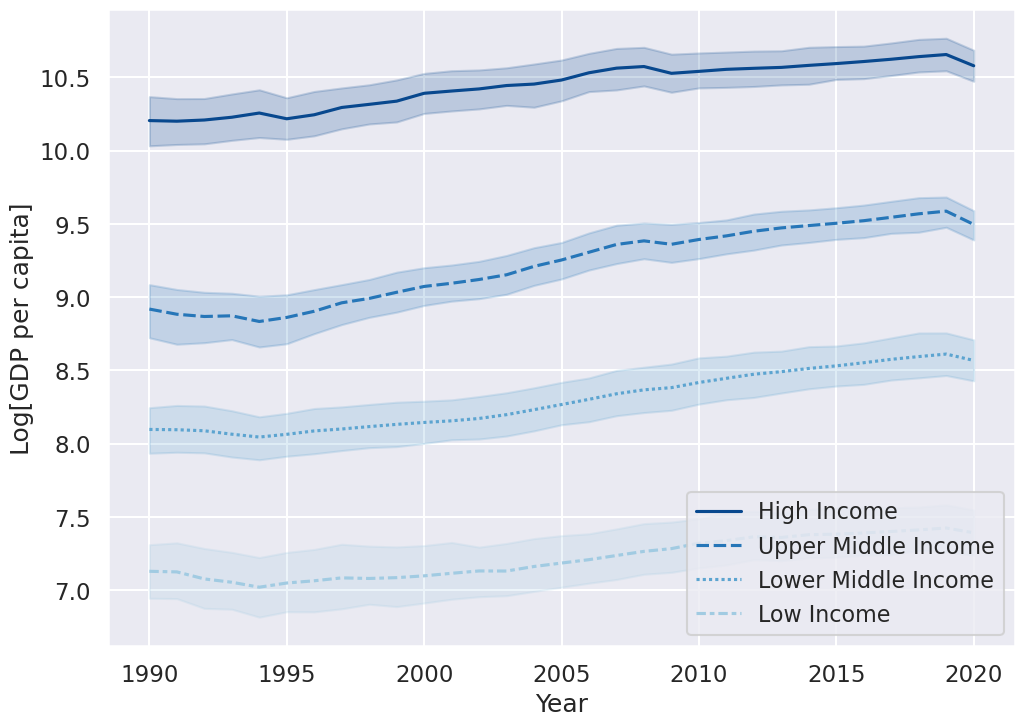

In [ ]:
fig

## GDP per capita across the world by WB Regions

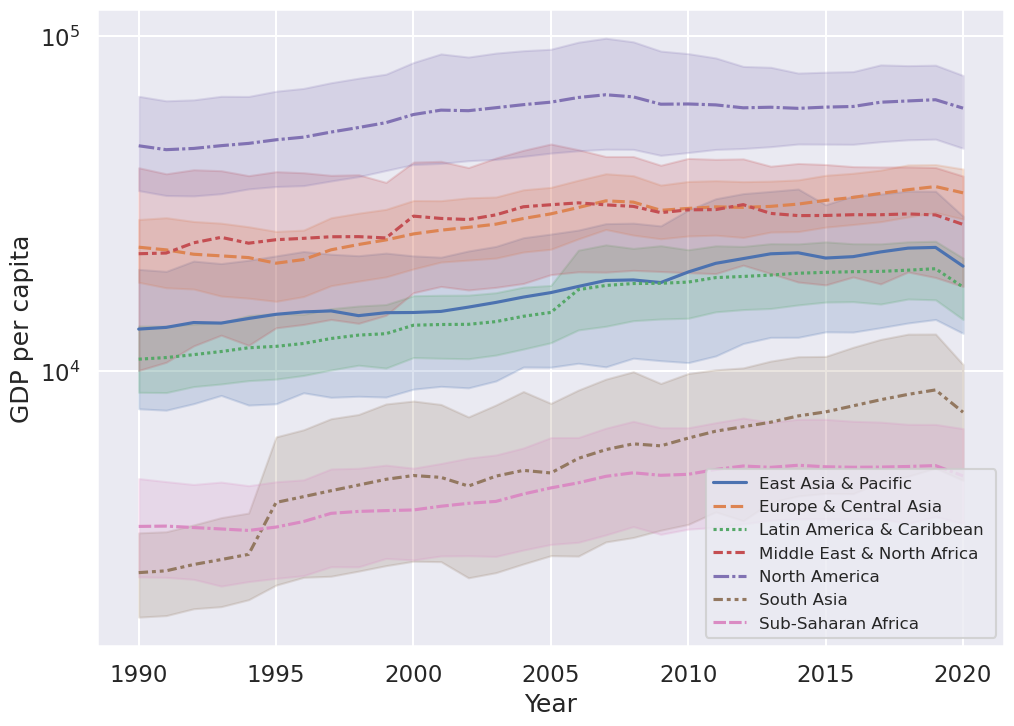

In [ ]:
#palette=sns.color_palette("Blues_r", wdi['region'].unique().shape[0]+6)[:wdi['region'].unique().shape[0]*2:2]
fig = my_xy_line_plot(wdi, 
                      x='year', 
                      y='gdp_pc', 
                      xlabel='Year',
                      ylabel='GDP per capita',
                      ylogscale=True,
                      filename='ln-gdp-pc-regions-TS.pdf',
                      style='region',
                      style_order=['East Asia & Pacific', 'Europe & Central Asia',
                                   'Latin America & Caribbean ', 'Middle East & North Africa',
                                   'North America', 'South Asia', 'Sub-Saharan Africa '],
                      #palette=palette,
                      OLS=False, 
                      labels=False,
                      legend_fontsize=12,
                      loc='lower right',
                      save=True)

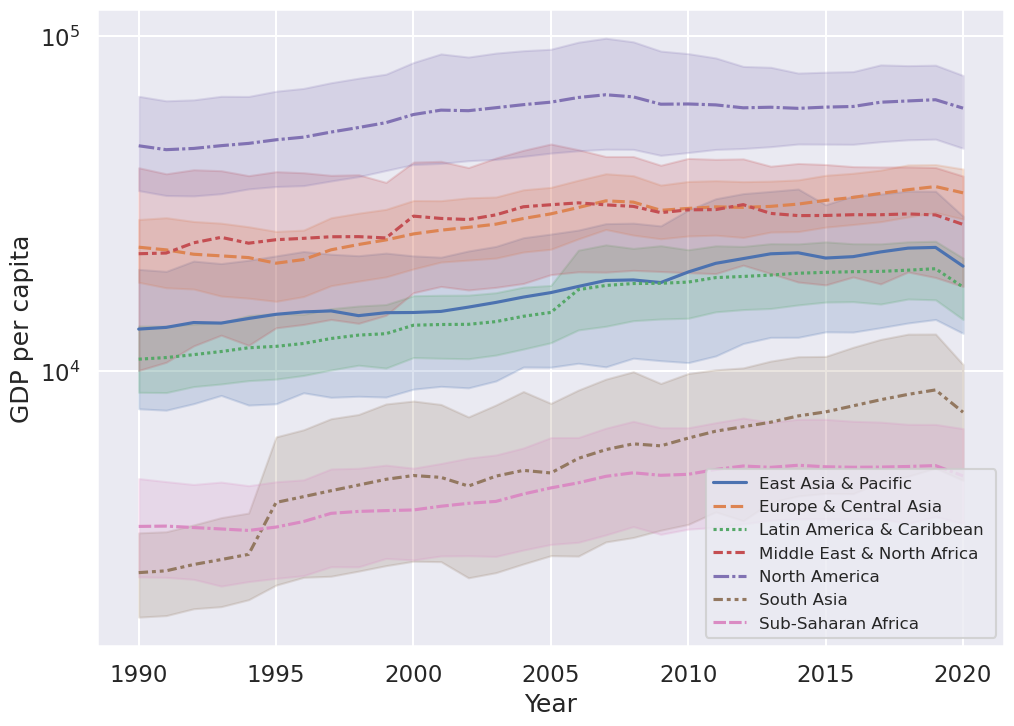

In [ ]:
fig

# Plots with 
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [ ]:
url = 'https://plotly.com/python/'
IFrame(url, width=800, height=400)

## Let's [select symbols to plot](https://plotly.com/python/marker-style/) so it looks like the previous ones and also to improve visibility

In [ ]:
symbols = ['circle', 'x', 'square', 'cross', 'diamond', 'star-diamond', 'triangle-up']
fig = px.scatter(dffig,
                 x="latitude", 
                 y="ln_gdp_pc", 
                 color='region',
                 symbol='region',
                 symbol_sequence=symbols,
                 hover_name='name',
                 hover_data=['iso3c', 'ln_pop', 'gdp_pc'],
                 size='ln_pop',
                 size_max=15,
                 trendline="ols",
                 trendline_scope="overall",
                 trendline_color_override="black",
                 labels={
                     "latitude": "Latitude",
                     "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                     "gdp_pc": "GDP per capita (" + str(year) + ")",
                     "region": "WB Region"
                 },
                 opacity=0.75,
                 height=800,
                )

In [ ]:
fig.show()

# Change marker borders

In [ ]:
fig.update_traces(marker=dict(#size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

In [ ]:
fig.show()

# Increase width of trend line

In [ ]:
tr_line=[]
for  k, trace  in enumerate(fig.data):
        if trace.mode is not None and trace.mode == 'lines':
            tr_line.append(k)
print(tr_line)
for id in tr_line:
    fig.data[id].update(line_width=3)

[7]


In [ ]:
fig.show()

# Change legend position

In [ ]:
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.25,
    xanchor="left",
    x=0.9
))

In [ ]:
fig.show()

# To save the figure use in your desired format
```python
fig.write_image(pathgraphs + "fig1.pdf")
fig.write_image(pathgraphs + "fig1.png")
fig.write_image(pathgraphs + "fig1.jpg")
```

In [ ]:
fig.write_image(pathgraphs + "ln-gdp-pc-latitude-plotly.pdf", height=1000, width=1500, scale=4)

## We can access the results of the regression in **plotly express**

In [ ]:
results = px.get_trendline_results(fig)
results.px_fit_results.iloc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     58.08
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           1.18e-12
Time:                        20:02:41   Log-Likelihood:                -271.78
No. Observations:                 191   AIC:                             547.6
Df Residuals:                     189   BIC:                             554.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9478      0.092     97.303      0.000       8.766       9.129
x1             0.0231      0.003      7.621      0.000       0.017       0.029
==============================================================================
Omnibus:                        0.534   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.656
Skew:                          -0.002   Prob(JB):                        0.720
Kurtosis:                       2.713   Cond. No.                         38.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Maps with
<center><a href="https://seaborn.pydata.org/index.html#"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/logo-wide-lightbg.svg" alt="seaborn" width=700/></a></center>

# To create maps we need to obtain *geographical information*

There are various types of data in **Geographic Information Systems (GIS)**

* Location of cities, resources, etc. (point data)

* Shape of rivers, borders, countries, etc. (shape data)

* Numerical data for locations (elevation, temperature, number of people)

## Download Country boundary data from [Natural Earth](http://www.naturalearthdata.com/)

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}

url = 'https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip'
r = requests.get(url, headers=headers)
countries = gp.read_file(io.BytesIO(r.content))

DriverError: '/vsimem/47c81f8707f045349db512b1a74cd800' not recognized as a supported file format.

In [ ]:
countries.head()

featurecla  scalerank  LABELRANK SOVEREIGNT SOV_A3  ADM0_DIF  LEVEL  \
0  Admin-0 country          0          2  Indonesia    IDN         0      2   
1  Admin-0 country          0          3   Malaysia    MYS         0      2   
2  Admin-0 country          0          2      Chile    CHL         0      2   
3  Admin-0 country          0          3    Bolivia    BOL         0      2   
4  Admin-0 country          0          2       Peru    PER         0      2   

                TYPE TLC      ADMIN  ... FCLASS_TR  FCLASS_ID FCLASS_PL  \
0  Sovereign country   1  Indonesia  ...      None       None      None   
1  Sovereign country   1   Malaysia  ...      None       None      None   
2  Sovereign country   1      Chile  ...      None       None      None   
3  Sovereign country   1    Bolivia  ...      None       None      None   
4  Sovereign country   1       Peru  ...      None       None      None   

  FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
0      None       None      None      None       None      None   
1      None       None      None      None       None      None   
2      None       None      None      None       None      None   
3      None       None      None      None       None      None   
4      None       None      None      None       None      None   

                                            geometry  
0  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...  
1  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...  
2  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...  
3  POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...  
4  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...  

[5 rows x 169 columns]

## The boundary file is a **geopandas** dataframe

Text(0.5, 1.0, 'WGS84 (lat/lon)')

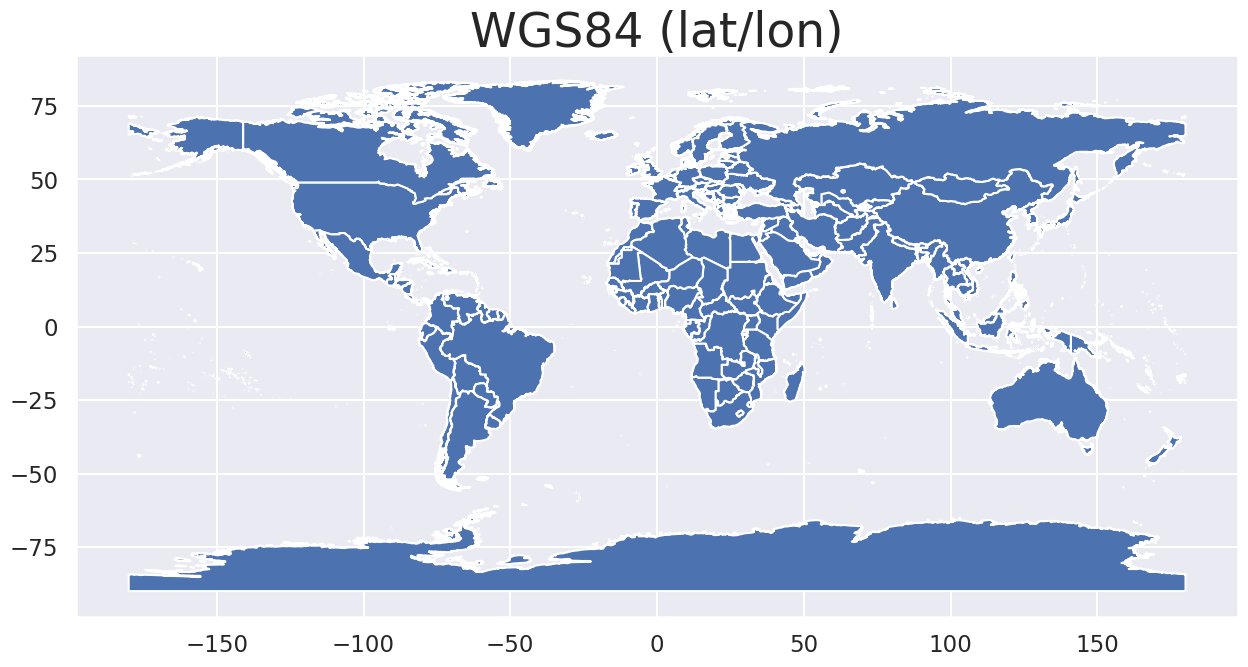

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
countries.plot(ax=ax)
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

## Merge with other data and plot

In [ ]:
dffig2 = countries.merge(dffig, left_on='ADM0_A3', right_on='iso3c')

Text(0.5, 1.0, 'WGS84 (lat/lon)')

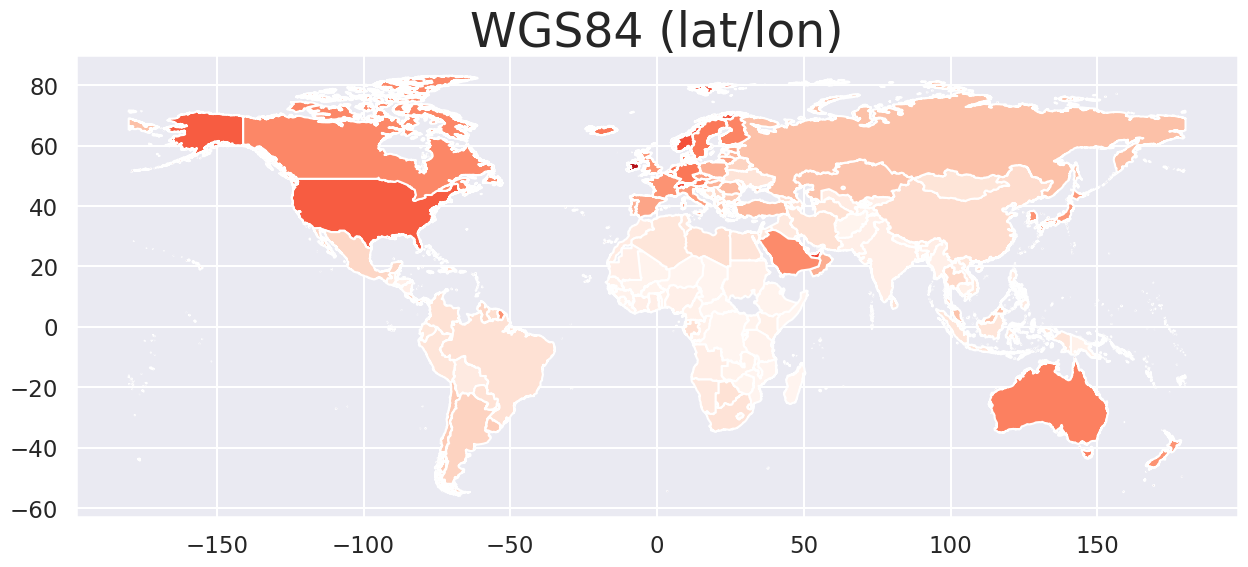

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
dffig2.plot(column='gdp_pc', ax=ax, cmap='Reds')
ax.set_title("WGS84 (lat/lon)", fontdict={'fontsize':34})

# Maps with [geoplot](https://residentmario.github.io/geoplot/)

In [ ]:
url = 'https://residentmario.github.io/geoplot/'
IFrame(url, width=800, height=400)

# Plot Countries

<GeoAxes: >

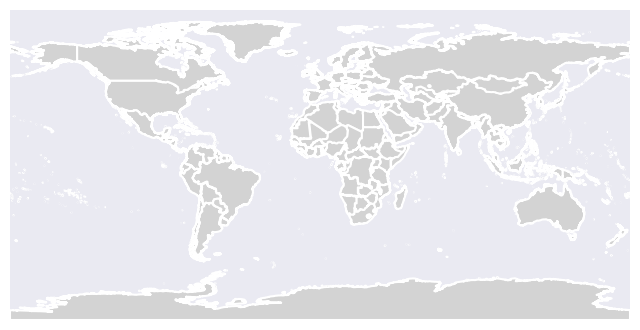

In [ ]:
gplt.polyplot(
    countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
    edgecolor='white', facecolor='lightgray',
    rasterized=True,
    extent=[-180, -90, 180, 90],
)

# Plot Data

<GeoAxes: >

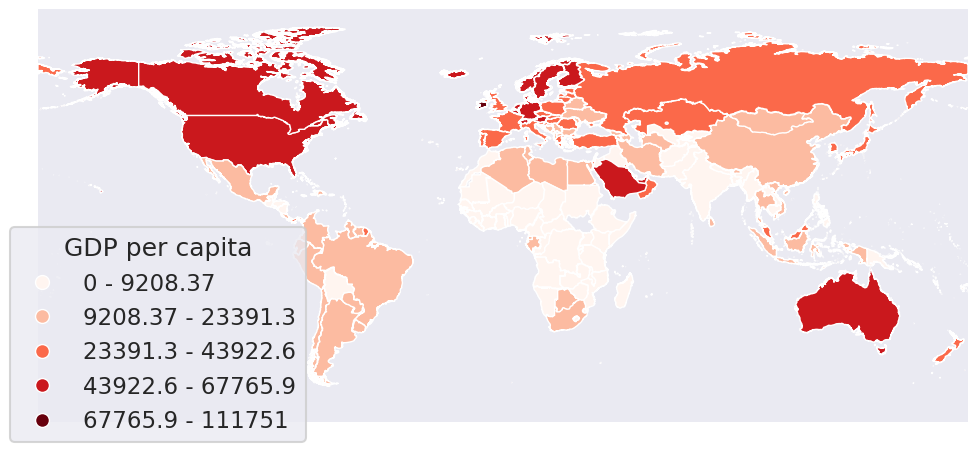

In [ ]:
gplt.choropleth(dffig2, hue='gdp_pc', 
                projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                edgecolor='white', 
                linewidth=1,
                cmap='Reds', legend=True,
                scheme='FisherJenks',
                legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                               'frameon': True,
                               'title':'GDP per capita',
                              },
                figsize=(12,8),
                rasterized=True,
               )

# Data and Borders

<GeoAxes: >

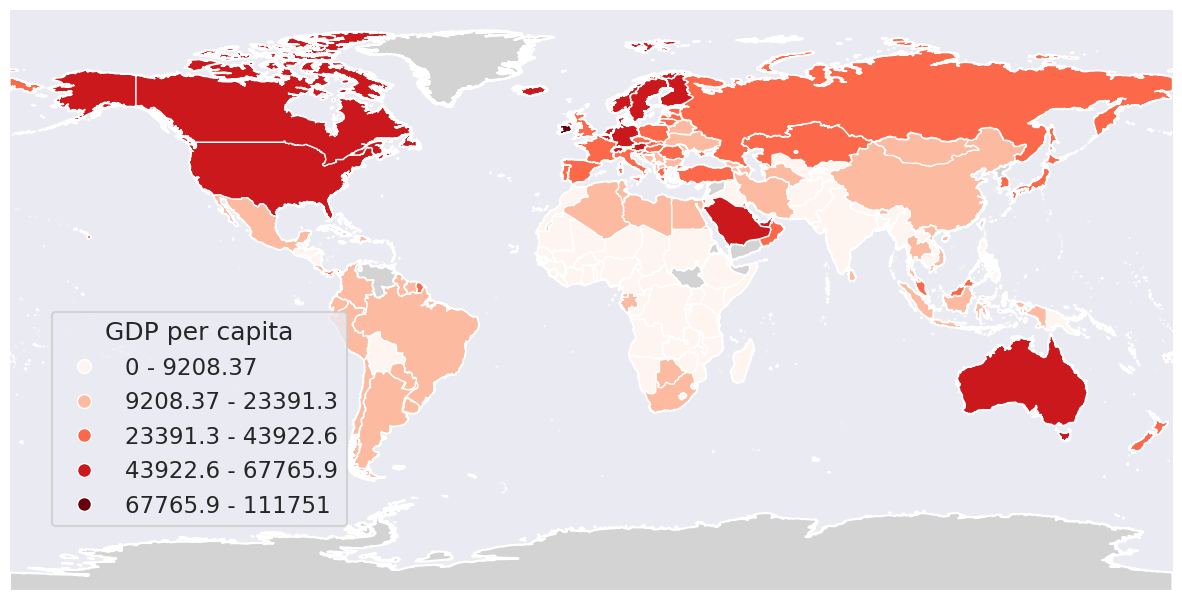

In [ ]:
ax = gplt.choropleth(dffig2, hue='gdp_pc', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
                     edgecolor='white', linewidth=1,
                     cmap='Reds', legend=True,
                     scheme='FisherJenks',
                     legend_kwargs={'bbox_to_anchor':(0.3, 0.5),
                                    'frameon': True,
                                    'title':'GDP per capita',
                                   },
                     figsize=(15,10),
                     rasterized=True,
                    )
gplt.polyplot(countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
              edgecolor='white', facecolor='lightgray',
              ax=ax,
              rasterized=True,
              extent=[-180, -90, 180, 90],
             )

# Use a nice function

In [ ]:
# Functions for plotting
def center_wrap(text, cwidth=32, **kw):
    '''Center Text (to be used in legend)'''
    lines = text
    #lines = textwrap.wrap(text, **kw)
    return "\n".join(line.center(cwidth) for line in lines)

def MyChloropleth(mydf, myfile='fig', myvar='gdp_pc',
                  mylegend='GDP per capita',
                  k=5,
                  extent=[-180, -90, 180, 90],
                  bbox_to_anchor=(0.25, 0.5),
                  edgecolor='white', facecolor='lightgray',
                  scheme='FisherJenks',
                  rasterized=False,
                  save=True,
                  percent=False,
                  rn=0,
                  **kwargs):
    # Chloropleth
    # Color scheme
    if scheme=='EqualInterval':
        scheme = mc.EqualInterval(mydf[myvar], k=k)
    elif scheme=='Quantiles':
        scheme = mc.Quantiles(mydf[myvar], k=k)
    elif scheme=='BoxPlot':
        scheme = mc.BoxPlot(mydf[myvar], k=k)
    elif scheme=='FisherJenks':
        scheme = mc.FisherJenks(mydf[myvar], k=k)
    elif scheme=='FisherJenksSampled':
        scheme = mc.FisherJenksSampled(mydf[myvar], k=k)
    elif scheme=='HeadTailBreaks':
        scheme = mc.HeadTailBreaks(mydf[myvar], k=k)
    elif scheme=='JenksCaspall':
        scheme = mc.JenksCaspall(mydf[myvar], k=k)
    elif scheme=='JenksCaspallForced':
        scheme = mc.JenksCaspallForced(mydf[myvar], k=k)
    elif scheme=='JenksCaspallSampled':
        scheme = mc.JenksCaspallSampled(mydf[myvar], k=k)
    elif scheme=='KClassifiers':
        scheme = mc.KClassifiers(mydf[myvar], k=k)
    # Format legend
    upper_bounds = scheme.bins
    # get and format all bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = mydf[myvar].min()
        else:
            lower_bound = upper_bounds[index-1]
        # format the numerical legend here
        if percent:
            bound = f'{lower_bound:.{rn}%} - {upper_bound:.{rn}%}'.format(width=rn)
        else:
            bound = f'{float(lower_bound):,.{rn}f} - {float(upper_bound):,.{rn}f}'.format(width=rn)
        bounds.append(bound)
    legend_labels = bounds
    #Plot
    ax = gplt.choropleth(
        mydf, hue=myvar, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        cmap='Reds', legend=True,
        scheme=scheme,
        legend_kwargs={'bbox_to_anchor': bbox_to_anchor,
                       'frameon': True,
                       'title':mylegend,
                       },
        legend_labels = legend_labels,
        figsize=(24, 16),
        rasterized=rasterized,
    )
    gplt.polyplot(
        countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=edgecolor, facecolor=facecolor,
        ax=ax,
        rasterized=rasterized,
        extent=extent,
    )
    if save:
        plt.savefig(pathgraphs + myfile + '.jpg', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '.png', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '.pdf', dpi=300, bbox_inches='tight')
    pass

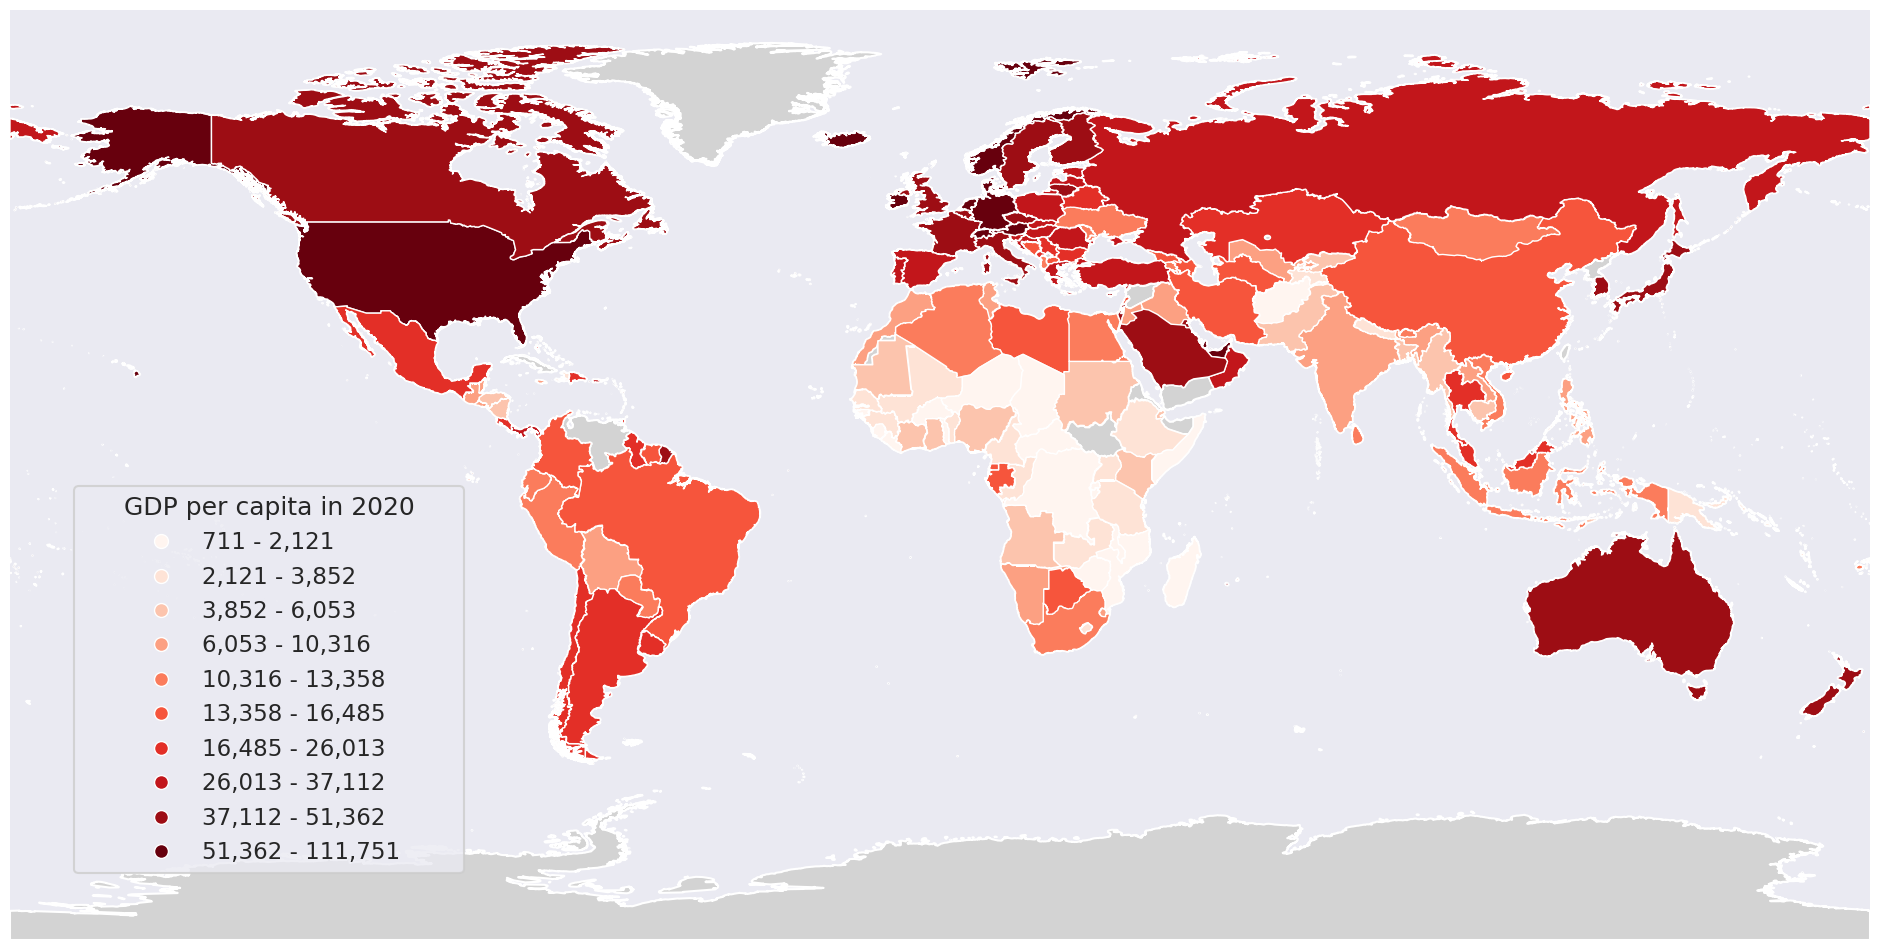

In [ ]:
mylegend = center_wrap(["GDP per capita in " + str(year)], cwidth=32, width=32)
MyChloropleth(dffig2, myfile='fig-gdp-pc-' + str(year), myvar='gdp_pc', mylegend=mylegend, k=10, scheme='Quantiles', save=True)

# Quick and Easy Maps with
<center><a href="https://plotly.com/python/"><img src="https://raw.githubusercontent.com/SMU-Econ-Growth/EconGrowthUG-Notebooks/main/pics/plot_ly-ar21.svg" alt="plotly express" width=700/></a></center>

In [ ]:
url = 'https://plotly.com/python/maps/'
IFrame(url, width=800, height=400)

# Map using classes (similar to **geoplot**)

## Choose a classifier and classify the data

In [ ]:
scheme = mc.Quantiles(dffig2['gdp_pc'], k=5)
classifier = mc.Quantiles.make(k=5, rolling=True)
dffig2['gdp_pc_q'] = classifier(dffig2['gdp_pc'])
dffig2['gdp_pc_qc'] = dffig2['gdp_pc_q'].apply(lambda x: scheme.get_legend_classes()[x].replace('[   ', '[').replace('( ', '('))

In [ ]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ")",
                    },
                    color_discrete_sequence=px.colors.sequential.Reds,
                    height=600, 
                    width=1000,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [ ]:
fig.show()

In [ ]:
fig = px.choropleth(dffig2.sort_values('gdp_pc_q', ascending=True), 
                    locations="iso3c",
                    color="gdp_pc_qc",
                    hover_name='name',
                    hover_data=['iso3c', 'gdp_pc' ,'ln_pop'],
                    labels={
                        "gdp_pc_qc": "GDP per capita (" + str(year) + ")",
                        "gdp_pc": "GDP per capita (" + str(year) + ")",
                        'iso3c':'ISO code',
                        "ln_pop": "Log[Population (" + str(year) + ")]",
                    },
                    color_discrete_sequence=px.colors.sequential.Blues,
                    height=600, 
                    width=1000,
                   )
# Change legend position
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.15,
    xanchor="left",
    x=0.05
))

In [ ]:
fig.show()

In [ ]:
fig = px.choropleth(dffig, 
                    locations="iso3c",
                    color="ln_gdp_pc",
                    hover_name='name',
                    hover_data=['iso3c', 'ln_pop'],
                    labels={
                        "ln_gdp_pc": "Log[GDP per capita (" + str(year) + ")]",
                    },
                    #color_continuous_scale=px.colors.sequential.Plasma,
                    color_continuous_scale="Reds",
                    height=600, 
                    width=1100,
                   )

In [ ]:
fig.show()

In [ ]:
fig.update_layout(coloraxis_colorbar=dict(
    orientation = 'h',
    yanchor="bottom", 
    xanchor="left", 
    y=-.2,
    x=0,
))
fig.update_coloraxes(colorbar_title_side='top')

In [ ]:
fig.show()

In [ ]:
# Change legend position
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="center",
    x=0.01,
    orientation='h',
))

In [ ]:
fig.show()

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP pc',
    )                  
)
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    margin=dict(
        l=5,
        r=5,
        b=10,
        t=10,
        pad=1
    ),
    paper_bgcolor="LightSteelBlue",
)

In [ ]:
fig.show()

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = dffig['iso3c'],
    z = dffig['gdp_pc'],
    text = dffig['name'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_tickprefix = '$',
    colorbar_title = 'GDP per capita',
    )                  
)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(
        l=1,
        r=1,
        b=1,
        t=1,
        pad=.1
    ),
    paper_bgcolor="LightSteelBlue",
)
# Change legend position
cb = fig.data[0].colorbar
cb.orientation = 'h'
cb.yanchor = 'bottom'
cb.xanchor = 'center'
cb.y = .1
cb.title.side = 'top'

In [ ]:
fig.show()

# <center>Exercises</center>

<div class="alert alert-block alert-warning">
    <b>Exercise 1:</b> Get WDI data on <b>patent applications by residents and non-residents in each country</b>. Create a new variable that shows the total patents for each country.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 2:</b> Using the <code>my_xy_plot</code> function plot the relation between <b>GDP per capita</b> and <b>total patents</b> in the years 1990, 1995, 2000, 2010, 2020.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 3:</b> Using the <code>my_xy_line_plot</code> function plot the evolution of <b>GDP per capita</b> and <b>total patents</b> by income groups and regions (separate figures).
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 4:</b> Plot the relation between patenting activity by <b>residents and non-residents</b> in the year 2015. Make sure to show the 45 degree line so you can see how similar they are.
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 5:</b> Create a static and a dynamic map for patenting activity in the year 2015 across the world. 
</div>

<div class="alert alert-block alert-warning">
<b>Exercise 6:</b> Explore the relation between economic development as measured by Log[GDP per capita] and patenting activity. Show the relation for residents, non-residents, and total, all in one nice looking table. Also, produce a few nice looking figures.
</div>

Notebook written by [Ömer Özak](http://omerozak.com) for his students in Economics at [Southern Methodist University](http://www.smu.edu). Feel free to use, distribute, or contribute.

[<center><img src="https://github.com/measuring-culture/Expanding-Measurement-Culture-Facebook-JRSI/blob/main/pics/SMUlogowWordmarkRB.jpg?raw=true" width="250"></center>](http://omerozak.com)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6edff53e-24cf-4345-9069-be947b9c4d19' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>